<a href="https://colab.research.google.com/github/gaurisharma360/steganography/blob/main/v4stego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 32.3 MB/s 
     |████████████████████████████████| 156 kB 61.7 MB/s 
     |████████████████████████████████| 181 kB 73.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1e6f7eeda3e6ba6cd773bbf255ad172e2e032691c31e732a97316bca6e611d0a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
### Imports ###
import tensorflow.python.keras.engine
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard

from keras.utils.layer_utils import get_source_inputs
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline


In [ ]:
#!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-08-01 07:47:47--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  17.1MB/s    in 17s     

2022-08-01 07:48:04 (13.6 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [5]:
!unzip /content/test.zip

Archive:  /content/test.zip
   creating: content/yolov5/tumour_brain-1/test/
   creating: content/yolov5/tumour_brain-1/test/images/
  inflating: content/yolov5/tumour_brain-1/test/images/gg--67-_jpg.rf.d309f2a857b158ad190910407dd3d87f.jpg  
  inflating: content/yolov5/tumour_brain-1/test/images/m1-59-_jpg.rf.3e776c188c7650a00caaeccb50e112e7.jpg  
  inflating: content/yolov5/tumour_brain-1/test/images/p--34-_jpg.rf.71e059776a549d9515fa722807628e24.jpg  
  inflating: content/yolov5/tumour_brain-1/test/images/m1-21-_jpg.rf.523a661b55112cdd4a687793a83cfbeb.jpg  
  inflating: content/yolov5/tumour_brain-1/test/images/image-198-_jpg.rf.f1adfad4e2e65c6bc7fc3bddb153b6e7.jpg  
  inflating: content/yolov5/tumour_brain-1/test/images/gg--82-_jpg.rf.5a0a189f70139d8946c451cda47508c4.jpg  
  inflating: content/yolov5/tumour_brain-1/test/images/p--44-_jpg.rf.31d33736a58029082caa4ee8c0e21a52.jpg  
  inflating: content/yolov5/tumour_brain-1/test/images/m--61-_jpg.rf.c8c88e50867f94ce75eb044f6bd7ece5.jpg

In [ ]:
!mkdir encoded

In [ ]:
!rm /content/tiny-imagenet-200/train1

rm: cannot remove '/content/tiny-imagenet-200/train1': Is a directory


In [6]:
### Constants ###
DATA_DIR = "/content/content/yolov5/tumour_brain-1/"
TRAIN_DIR = os.path.join(DATA_DIR, "toenc")
#TEST_DIR = os.path.join(DATA_DIR, "test")
#ENC_DIR="/content/encoded"
IMG_SHAPE = (64, 64)

In [9]:
def load_dataset_small(num_images_per_class_train=100):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into testing dataset.
    """
    X_train = []
   # X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR,'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
   # test_dir = os.path.join(TEST_DIR, 'images')
    #test_imgs = os.listdir(test_dir)
    #random.shuffle(test_imgs)
    #for img_name_i in test_imgs[0:num_images_test]:
    #    img_i = image.load_img(os.path.join(test_dir, img_name_i))
      #  x = image.img_to_array(img_i)
      #  X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train)#, np.array(X_test)

In [12]:
# Load dataset.
#X_train_orig, X_test_orig = load_dataset_small()
X_train_orig = load_dataset_small()
# Normalize image vectors.
X_train = X_train_orig/255.
#X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
#print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 200
X_train shape: (200, 416, 416, 3)


In [13]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

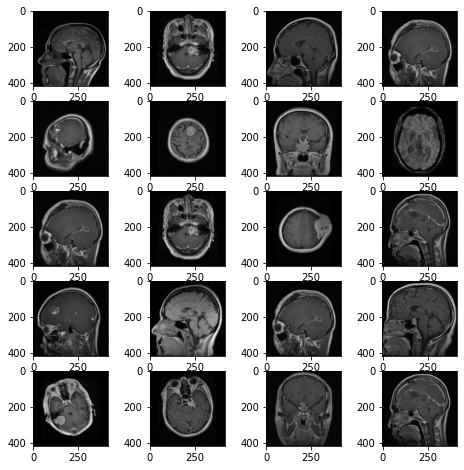

In [14]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [15]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    
    s_loss = beta * K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss, metrics=['accuracy'])
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss, metrics=['accuracy'])
    
    return encoder, decoder, autoencoder

In [16]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

In [17]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [18]:
NB_EPOCHS = 50
BATCH_SIZE = 3

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

Epoch 1 | Batch:  99 of 100. Loss AE   37218.25 | Loss Rev   22295.81: 100%|██████████| 34/34 [01:37<00:00,  2.87s/it]
Epoch 2 | Batch:  99 of 100. Loss AE   11287.05 | Loss Rev    7518.72: 100%|██████████| 34/34 [01:07<00:00,  1.99s/it]
Epoch 3 | Batch:  99 of 100. Loss AE    5330.78 | Loss Rev    3056.83: 100%|██████████| 34/34 [01:08<00:00,  2.02s/it]
Epoch 4 | Batch:  99 of 100. Loss AE    3817.83 | Loss Rev    2383.06: 100%|██████████| 34/34 [01:09<00:00,  2.03s/it]
Epoch 5 | Batch:  99 of 100. Loss AE    4392.71 | Loss Rev    2591.08: 100%|██████████| 34/34 [01:09<00:00,  2.04s/it]
Epoch 6 | Batch:  99 of 100. Loss AE    2247.90 | Loss Rev    1268.64: 100%|██████████| 34/34 [01:09<00:00,  2.05s/it]
Epoch 7 | Batch:  99 of 100. Loss AE    1632.24 | Loss Rev     933.89: 100%|██████████| 34/34 [01:09<00:00,  2.04s/it]
Epoch 8 | Batch:  99 of 100. Loss AE    4186.50 | Loss Rev    2784.38: 100%|██████████| 34/34 [01:09<00:00,  2.04s/it]
Epoch 9 | Batch:  99 of 100. Loss AE    2055.54 

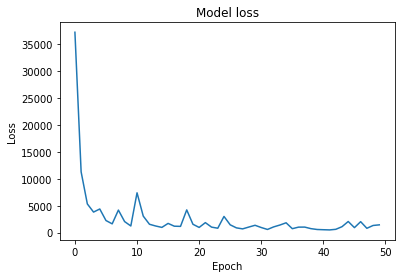

In [19]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [20]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [22]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [23]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 4.12644
C error per pixel [0, 255]: 5.7904453


AttributeError: ignored

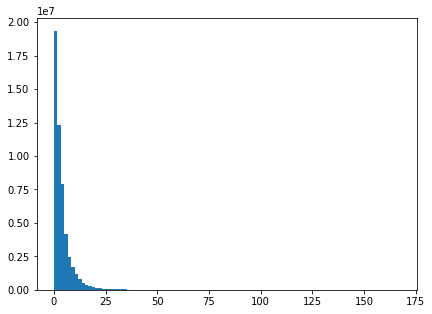

In [24]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)


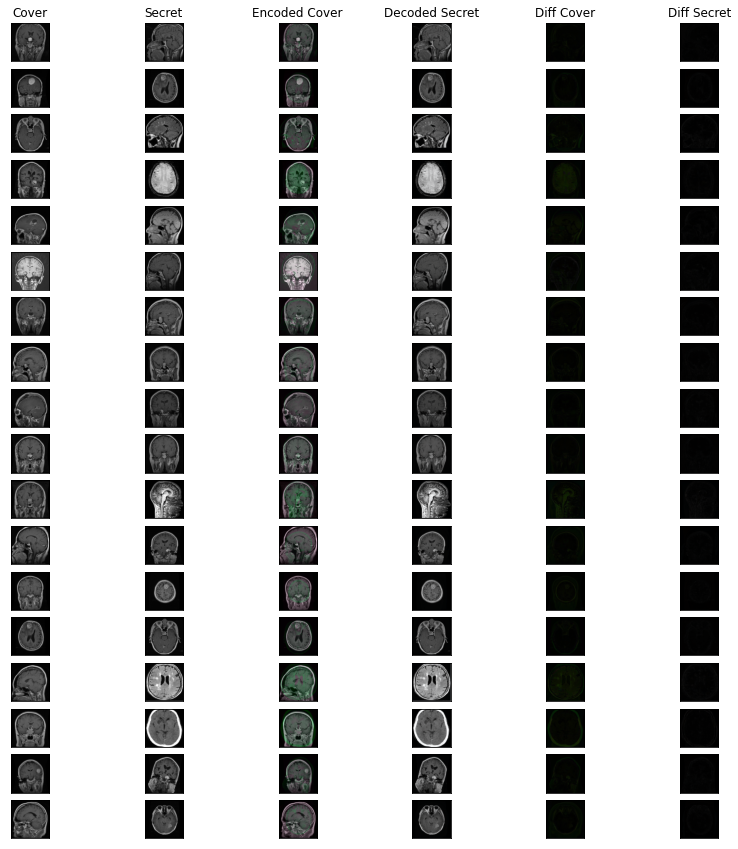

In [25]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 18

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
#rand_indx = [random.randint(0, 1000) for x in range(n)]
for i, idx in enumerate(range(0, n)):
#for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')

    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')

    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')
   
    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()


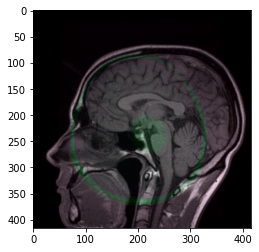

In [27]:
for i in range (1, 100):
  plt.imshow(decoded_C[i])
  plt.savefig('encoded/{}'.format(i))

In [28]:
#to download test data to encode
!zip -r /content/encoded.zip /content/encoded

  adding: content/encoded/ (stored 0%)
  adding: content/encoded/19.png (deflated 1%)
  adding: content/encoded/35.png (deflated 1%)
  adding: content/encoded/41.png (deflated 1%)
  adding: content/encoded/18.png (deflated 1%)
  adding: content/encoded/37.png (deflated 1%)
  adding: content/encoded/69.png (deflated 1%)
  adding: content/encoded/9.png (deflated 1%)
  adding: content/encoded/10.png (deflated 1%)
  adding: content/encoded/27.png (deflated 1%)
  adding: content/encoded/24.png (deflated 1%)
  adding: content/encoded/34.png (deflated 1%)
  adding: content/encoded/51.png (deflated 1%)
  adding: content/encoded/45.png (deflated 1%)
  adding: content/encoded/70.png (deflated 1%)
  adding: content/encoded/17.png (deflated 1%)
  adding: content/encoded/76.png (deflated 1%)
  adding: content/encoded/99.png (deflated 1%)
  adding: content/encoded/46.png (deflated 1%)
  adding: content/encoded/48.png (deflated 1%)
  adding: content/encoded/67.png (deflated 1%)
  adding: content/enco

In [ ]:
#import os
#import shutil

#results_dir = os.path.dirname('/content/encoded')
#for i in range(1, 4):
    # Randomly sample from training dataset
   # plt.savefig('encoded/{}'.format(plt.savefig("Encoded {}".format(i))))
   # plt.imshow(decoded_C[i])
   #plt.savefig("Encoded {}".format(i))
   # plt.savefig(results_dir + "Encoded {}".format(i))

In [ ]:
#import os
#import shutil

#results_dir = os.path.dirname('/content/encoded')
#for i in Encoded Cover:
    # Randomly sample from training dataset
   # plt.savefig('encoded/{}'.format(i))
   # plt.imshow(decoded_C[i])
   #plt.savefig("Encoded {}".format(i))
   # plt.savefig(results_dir + "Encoded {}".format(i))

SyntaxError: ignored